In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
import keras

from keras import layers,metrics
from keras.optimizers import RMSprop
from keras.layers import Dense, LSTM, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import PReLU, ELU
from keras.models import Sequential, load_model
from keras.utils import np_utils, multi_gpu_model

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder 
from sklearn.utils import shuffle as reset
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedShuffleSplit
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import log_loss,make_scorer

from matplotlib.colors import LogNorm
# import 
from matplotlib.pylab import plt
from copy import deepcopy
from datetime import datetime
from imblearn.over_sampling import RandomOverSampler #https://imbalanced-learn.org/stable/generated/imblearn.over_sampling.RandomOverSampler.html?highlight=randomoversampler
from frplayer import FilterResponseNormalization

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [2]:
def train_test_split_DataFrame(data, test_size=0.2, considerTime=True, random_state=None):
    # ConsiderTime-------trainDF和testDF分割时是否考虑时间问题，即是否需要随机打乱。True:按照‘Dates’列进行降序排列,False：随机打乱样本的顺序，
    if considerTime:
        data=data.sort_values(by="Dates", ascending=True)
    else:
        data=reset(data, random_state=random_state)
    train=data[int(len(data)*test_size):].reset_index(drop=True)
    test=data[:int(len(data)*test_size)].reset_index(drop=True)
    return train, test

In [3]:
def parse_time(x):
    if '-' in x:
        DD=datetime.strptime(x,"%Y-%m-%d %H:%M:%S")#jjs
    else:
        DD=datetime.strptime(x,"%Y/%m/%d %H:%M")#zj    
    time=DD.hour#*60+DD.minute
    day=DD.day
    month=DD.month
    year=DD.year
    return time,day,month,year
def Dates2TDMY(x):
    if '-' in x:
        DD=datetime.strptime(x,"%Y-%m-%d %H:%M:%S")#jjs
    else:
        DD=datetime.strptime(x,"%Y/%m/%d %H:%M")#zj  
    time=DD.hour#*60+DD.minute
    day=DD.day
    month=DD.month
    year=DD.year
    #T_D_M_Y=str(time)+str(day)+str(month)+str(year)
    T_D_M_Y=str(time)+str(day)+str(month)
    return T_D_M_Y
def get_season(x):
    summer=0
    fall=0
    winter=0
    spring=0
    if (x in [5, 6, 7]):
        summer=1
    if (x in [8, 9, 10]):
        fall=1
    if (x in [11, 0, 1]):
        winter=1
    if (x in [2, 3, 4]):
        spring=1
    return summer, fall, winter, spring

In [4]:
def field2Vec(trainDF,testDF,fieldStr):
    fields=sorted(trainDF[fieldStr].unique())
    categories=sorted(trainDF["Category"].unique())
    C_counts=trainDF.groupby(["Category"]).size()
    F_C_counts=trainDF.groupby([fieldStr,"Category"]).size()
    F_counts=trainDF.groupby([fieldStr]).size()
    logodds={}
    logoddsPF={}
    MIN_CAT_COUNTS=2
    default_logodds=np.log(C_counts/len(trainDF))-np.log(1.0-C_counts/float(len(trainDF)))
    for f in fields:
        PA=F_counts[f]/float(len(trainDF))
        logoddsPF[f]=np.log(PA)-np.log(1.-PA)
        logodds[f]=deepcopy(default_logodds)
        for cat in F_C_counts[f].keys():
            if (F_C_counts[f][cat]>MIN_CAT_COUNTS) and F_C_counts[f][cat]<F_counts[f]:
                PA=F_C_counts[f][cat]/float(F_counts[f])
                logodds[f][categories.index(cat)]=np.log(PA)-np.log(1.0-PA)
        logodds[f]=pd.Series(logodds[f])
        logodds[f].index=range(len(categories))
    ########此部分代码，从逻辑上不应该出现在此处，但是为了编程的方便，放在了此处#########
    #fieldsTest=sorted(testDF[fieldStr].unique())
    #N_count=0
    #for f in fieldsTest:
        #if f not in fields:
            #logoddsPF[f]=-50.0  #np.log(0.)-np.log(1.)=-inf,便于计算，改为-99999.0
            #logodds[f]=deepcopy(default_logodds)
            #pa=1.0/float(len(categories))
            #logodds[f][range(len(categories))]=np.log(pa)-np.log(1.0-pa)
            #logodds[f]=pd.Series(logodds[f])
            #logodds[f].index=range(len(categories))
            #N_count=N_count+1
    #print(fieldStr+' N_count: '+str(N_count))
    ########此部分代码，从逻辑上不应该出现在此处，但是为了编程的方便，放在了此处#########
    #引进代码原作者的新思想
    if testDF.shape[0]>0: #如果testDF里有样本,......
        new_fields=sorted(testDF[fieldStr].unique())
        new_F_counts=testDF.groupby(fieldStr).size()
        only_new=set(new_fields+fields)-set(fields)
        only_old=set(new_fields+fields)-set(new_fields)
        in_both=set(new_fields).intersection(fields)
        print('# only_new_fieldds:'+str(len(only_new)))
        for f in only_new:
            PA=new_F_counts[f]/float(len(testDF)+len(trainDF))
            logoddsPF[f]=np.log(PA)-np.log(1.-PA)
            logodds[f]=deepcopy(default_logodds)
            logodds[f].index=range(len(categories))
        for f in in_both:
            PA=(F_counts[f]+new_F_counts[f])/float(len(testDF)+len(trainDF))
            logoddsPF[f]=np.log(PA)-np.log(1.-PA)    
    return logodds,logoddsPF

In [12]:
def parse_data(df,logodds_A,logoddsPF_A,logodds_T,logoddsPF_T,needT_D_M_Y=False):
    feature_list=df.columns.tolist()
    if "Descript" in feature_list:
        feature_list.remove("Descript")
    if "Resolution" in feature_list:
        feature_list.remove("Resolution")
    if "Category" in feature_list:
        feature_list.remove("Category")
    if "Id" in feature_list:
        feature_list.remove("Id")

    cleanData=df[feature_list]
    cleanData.index=range(len(df))
    print("Creating address features")###Creating address features###
    address_features=cleanData["Address"].apply(lambda x: logodds_A[x])
    address_features.columns=["logodds_A"+str(x) for x in range(len(address_features.columns))]
    if needT_D_M_Y:
        print("Creating time T_D_M_Y features")###Creating time T_D_M_Y features###
        T_D_M_Y_features=cleanData["T_D_M_Y"].apply(lambda xx: logodds_T[xx])
        T_D_M_Y_features.columns=["logodds_T"+str(xx) for xx in range(len(T_D_M_Y_features.columns))]

    print("Parsing dates")            ###Creating address features###
    cleanData["Time"], cleanData["Day"], cleanData["Month"], cleanData["Year"]=zip(*cleanData["Dates"].apply(parse_time))
    #     dummy_ranks_DAY = pd.get_dummies(cleanData['DayOfWeek'], prefix='DAY')
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    #     cleanData["DayOfWeek"]=cleanData["DayOfWeek"].apply(lambda x: days.index(x)/float(len(days)))
    print("Creating one-hot variables")
    dummy_ranks_PD = pd.get_dummies(cleanData['PdDistrict'], prefix='PD')
    dummy_ranks_DAY = pd.get_dummies(cleanData["DayOfWeek"], prefix='DAY')
    cleanData["IsInterection"]=cleanData["Address"].apply(lambda x: 1 if "/" in x else 0)
    cleanData["logoddsPF_A"]=cleanData["Address"].apply(lambda x: logoddsPF_A[x])
    if needT_D_M_Y:
        cleanData["logoddsPF_T"]=cleanData["T_D_M_Y"].apply(lambda x: logoddsPF_T[x])
    print("droping processed columns")
    cleanData=cleanData.drop("PdDistrict",axis=1)
    cleanData=cleanData.drop("DayOfWeek",axis=1)
    cleanData=cleanData.drop("Address",axis=1)    
    cleanData=cleanData.drop("Dates",axis=1)
    if needT_D_M_Y:
        cleanData=cleanData.drop("T_D_M_Y",axis=1)
    feature_list=cleanData.columns.tolist()
    print("joining one-hot features")
    if needT_D_M_Y:
        features = cleanData[feature_list].join(dummy_ranks_PD.iloc[:,:]).join(dummy_ranks_DAY.iloc[:,:]).join(address_features.iloc[:,:]).join(T_D_M_Y_features.iloc[:,:])
    else:
        features = cleanData[feature_list].join(dummy_ranks_PD.iloc[:,:]).join(dummy_ranks_DAY.iloc[:,:]).join(address_features.iloc[:,:])
    print("creating new features")
    features["IsDup"]=pd.Series(features.duplicated()|features.duplicated(keep='last')).apply(int)
    features["Awake"]=features["Time"].apply(lambda x: 1 if (x==0 or (x>=8 and x<=23)) else 0)
    features["Summer"], features["Fall"], features["Winter"], features["Spring"]=zip(*features["Month"].apply(get_season))
    if "Category" in df.columns:
        labels = df["Category"].astype('category')
    else:
        labels=None
    return features,labels

In [7]:
def generator(X, Y, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(X) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, X.shape[-1]))
        targets = np.zeros((len(rows),Y.shape[1]))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = X[indices]
            targets[j] = Y[rows[j]+delay]
        yield samples, targets
    #Now here is the data generator that we will use. It yields a tuple (samples, targets) where samples is one batch of input data and targets is the corresponding array of target temperatures. It takes the following arguments:
        # •data: The original array of floating point data, which we just normalized in the code snippet above.
        # •lookback: How many timesteps back should our input data go.
        # •delay: How many timesteps in the future should our target be.
        # •min_index and max_index: Indices in the data array that delimit which timesteps to draw from. This is useful for keeping a segment of the data for validation and another one for testing.
        # •shuffle: Whether to shuffle our samples or draw them in chronological order.
        # •batch_size: The number of samples per batch.
        # •step: The period, in timesteps, at which we sample data. We will set it 6 in order to draw one data point every hour.

In [13]:
#Import data
ConsiderTime=False# True##trainDF和testDF分割时是否考虑时间问题，即是否需要随机打乱。True:按照‘Dates’列进行降序排列,False：随机打乱样本的顺序，
Rate_ALL=0.0 #0.0即不保留测试机
needOverSampler=False
needT_D_M_Y=False
allDF=pd.read_csv("./train_addrCorrect.csv")
print('The shape of OrginalAllDF: '+str(allDF.shape))

xy_scaler=preprocessing.StandardScaler()
xy_scaler.fit(allDF[["X","Y"]])
allDF[["X","Y"]]=xy_scaler.transform(allDF[["X","Y"]])
allDF=allDF[abs(allDF["Y"])<100]
allDF.index=range(len(allDF))
print('The shape of AllDF after del wrong X and Y values: '+str(allDF.shape))

def listCat(x):
    return list(x)
allDF.drop_duplicates(inplace=True,subset=['Dates', 'DayOfWeek', 'PdDistrict', 'Address', 'X', 'Y', 'Category'])
Train_duplicated=pd.pivot_table(allDF,index=['Dates','DayOfWeek','PdDistrict', 'Address', 'X', 'Y'], values='Category',aggfunc=[len,listCat])
print('The shape of AllDF after drop_duplicates: '+str(allDF.shape))
print(Train_duplicated.shape)

trainDF,testDF=train_test_split_DataFrame(allDF, test_size=Rate_ALL, considerTime=ConsiderTime, random_state=None)
print('Address_counts_allDF_trainDF_testDF: ' + str(len(allDF["Address"].unique())) + '_'+ str(len(trainDF["Address"].unique())) + '_' + str(len(testDF["Address"].unique())))

N_AllSample=allDF.shape[0]
N_AllTrain=trainDF.shape[0]
N_AllTest=testDF.shape[0]
N_CLASS=len(allDF["Category"].unique())
print('The # of AllDF, AllTrain, AllTest, is: '+str(N_AllSample)+','+str(N_AllTrain)+','+str(N_AllTest))
#################Now proceed as before#################
print('-----------LOGOODS: Address-------------')
logodds_A,logoddsPF_A=field2Vec(trainDF,testDF,"Address")
if needT_D_M_Y:
    trainDF["T_D_M_Y"]=trainDF["Dates"].apply(Dates2TDMY)
    trainDF["T_D_M_Y"]=trainDF["T_D_M_Y"]+trainDF["DayOfWeek"]
    if Rate_ALL>0:
        testDF[["X","Y"]]=xy_scaler.transform(testDF[["X","Y"]])
        testDF["T_D_M_Y"]=testDF["Dates"].apply(Dates2TDMY)
        testDF["T_D_M_Y"]=testDF["T_D_M_Y"]+testDF["DayOfWeek"]
    print('-----------LOGOODS: T_D_M_Y-------------')
    logodds_T,logoddsPF_T=field2Vec(trainDF,testDF,"T_D_M_Y")    
else:
    logodds_T=None
    logoddsPF_T=None
    
print('-----------LOGOODS: parse_data of Alltrain  -------------')
features, labels=parse_data(trainDF,logodds_A,logoddsPF_A,logodds_T,logoddsPF_T,needT_D_M_Y) 
if Rate_ALL>0:
    print('-----------LOGOODS: parse_data of Alltest  -------------')
    features_test, labels_test=parse_data(testDF,logodds_A,logoddsPF_A,logodds_T,logoddsPF_T,needT_D_M_Y)###########和训练集使用同样的时间和地点Logoodds值#####
    x_test=features_test.values
    y_test=labels_test.values
    y_test = keras.utils.to_categorical(LabelEncoder().fit_transform(np.array(y_test)), num_classes=N_CLASS)

print(features.columns.tolist())
print(len(features.columns))

collist=features.columns.tolist()
scaler = preprocessing.StandardScaler()
scaler.fit(features)
features[collist]=scaler.transform(features)
if Rate_ALL>0:
    features_test[collist]=scaler.transform(features_test)###########和训练集使用同样的scaler值#####
######################################################
#############################先进行过采样，然后再根据时间来排序##################################
if needOverSampler:
    print('------------RandomOverSampler--------------')
    ros = RandomOverSampler()
    featuresArrayOverSampler, labelsArrayOverSampler = ros.fit_resample(features.values,labels.values)#####过采样#####
    N_AllTrain_OverSampler=int(featuresArrayOverSampler.shape[0])
    print('Shape of OverSampler of AllTrain: '+str(featuresArrayOverSampler.shape))
else:
    featuresArrayOverSampler=features.values
    labelsArrayOverSampler=labels.values
    N_AllTrain_OverSampler=int(featuresArrayOverSampler.shape[0])
    print('------------Attention: we do not RandomOverSampler---------------')
if ConsiderTime:
    #####按照年（第6列）月（第5列）日（第4列）时（第3列）排序
    print('------------Sort--------------')
    time_temp=featuresArrayOverSampler[:,2]+np.dot(featuresArrayOverSampler[:,3],100)+np.dot(featuresArrayOverSampler[:,4],10000)+np.dot(featuresArrayOverSampler[:,5],1000000)
    features_label_time=np.column_stack((featuresArrayOverSampler,labelsArrayOverSampler))
    features_label_time=np.column_stack((features_label_time,time_temp))
    features_label_time =features_label_time[np.argsort(features_label_time[:,-1])]
    labelsArrayOverSampler=features_label_time[:,-2]
    featuresArrayOverSampler=features_label_time[:,0:featuresArrayOverSampler.shape[1]]
    del features_label_time
    #############################先进行过采样，然后再根据时间来排序----结束############################

The shape of OrginalAllDF: (878049, 9)
The shape of AllDF after del wrong X and Y values: (877982, 9)
The shape of AllDF after drop_duplicates: (812529, 9)
(689038, 2)
Address_counts_allDF_trainDF_testDF: 23191_23191_0
The # of AllDF, AllTrain, AllTest, is: 812529,812529,0
-----------LOGOODS: Address-------------
-----------LOGOODS: parse_data of Alltrain  -------------
Creating address features
Parsing dates


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Creating one-hot variables
droping processed columns
joining one-hot features
creating new features
['X', 'Y', 'Time', 'Day', 'Month', 'Year', 'IsInterection', 'logoddsPF_A', 'PD_BAYVIEW', 'PD_CENTRAL', 'PD_INGLESIDE', 'PD_MISSION', 'PD_NORTHERN', 'PD_PARK', 'PD_RICHMOND', 'PD_SOUTHERN', 'PD_TARAVAL', 'PD_TENDERLOIN', 'DAY_Friday', 'DAY_Monday', 'DAY_Saturday', 'DAY_Sunday', 'DAY_Thursday', 'DAY_Tuesday', 'DAY_Wednesday', 'logodds_A0', 'logodds_A1', 'logodds_A2', 'logodds_A3', 'logodds_A4', 'logodds_A5', 'logodds_A6', 'logodds_A7', 'logodds_A8', 'logodds_A9', 'logodds_A10', 'logodds_A11', 'logodds_A12', 'logodds_A13', 'logodds_A14', 'logodds_A15', 'logodds_A16', 'logodds_A17', 'logodds_A18', 'logodds_A19', 'logodds_A20', 'logodds_A21', 'logodds_A22', 'logodds_A23', 'logodds_A24', 'logodds_A25', 'logodds_A26', 'logodds_A27', 'logodds_A28', 'logodds_A29', 'logodds_A30', 'logodds_A31', 'logodds_A32', 'logodds_A33', 'logodds_A34', 'logodds_A35', 'logodds_A36', 'logodds_A37', 'logodds_A38',

In [14]:
if Rate_ALL>0:
    print('------------RandomOverSampler for AllTest--------------')
    ros = RandomOverSampler()
    featuresArray_test, labelsArray_test = ros.fit_resample(features_test.values,labels_test.values)#####过采样#####
    N_AllTest_OverSampler=int(featuresArray_test.shape[0])
    labelsArray_test = keras.utils.to_categorical(LabelEncoder().fit_transform(np.array(labelsArray_test)), num_classes=N_CLASS)
    print('Shape of OverSampler of AllTest: '+str(featuresArray_test.shape))

In [15]:
####TEST DNN
print('------------Building DNN model--------------')
ShuffleInTraining=True
N_EPOCHS=20
N_HN_1=64
N_HN=64
N_LAYERS=1
N_BATCH=64
Rate_Val=0.5
N_Val_OverSampler=int(np.around(N_AllTrain_OverSampler*Rate_Val))
N_Train_OverSampler=int(N_AllTrain_OverSampler-N_Val_OverSampler)
N_CLASS=len(allDF["Category"].unique())
input_dim=featuresArrayOverSampler.shape[1]
output_dim=N_CLASS

model = Sequential()
model.add(Dense(N_HN_1,input_dim=input_dim))
# model.add(BatchNormalization())
model.add(FilterResponseNormalization(axis=None))
model.add(PReLU())
# model.add(Dropout(dp))
for i in range(N_LAYERS):
    model.add(Dense(N_HN))
#     model.add(BatchNormalization())   
    model.add(FilterResponseNormalization(axis=None))
    model.add(PReLU())
#   model.add(Dropout(dp))
# model.add(BatchNormalization())
model.add(FilterResponseNormalization(axis=None))
model.add(Dense(output_dim))
model.add(Activation('softmax'))
# model = multi_gpu_model(model, 2)gfyht76```
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy', metrics.top_k_categorical_accuracy])

x_train,x_val,y_train,y_val = train_test_split(featuresArrayOverSampler,labelsArrayOverSampler,test_size=N_Val_OverSampler,train_size=N_Train_OverSampler, shuffle=True)
# ros_train = RandomOverSampler()
# x_train, y_train = ros_train.fit_resample(x_train,y_train)#####过采样#####
# ros_val = RandomOverSampler()
# x_val, y_val = ros_val.fit_resample(x_val,y_val)#####过采样#####


y_train = keras.utils.to_categorical(LabelEncoder().fit_transform(np.array(y_train)), num_classes=N_CLASS)
y_val = keras.utils.to_categorical(LabelEncoder().fit_transform(np.array(y_val)), num_classes=N_CLASS)
print('------------DNN Training Go! Go! Go!!!!-----------')
# fitting=model.fit(x_train, y_train, epochs=N_EPOCHS, batch_size=N_BATCH,verbose=2,validation_data=(x_val,y_val),shuffle=True)
fitting=model.fit(x_train, y_train, epochs=N_EPOCHS, batch_size=N_BATCH,verbose=2,validation_data=(x_val,y_val),shuffle=True)

# acc_test, test_score,fitting, model = build_and_fit_model(features_train.values,labels_train,x_val=features_test.values,y_test=labels_test,hn=N_HN,layers=N_LAYERS,epochs=N_EPOCHS,verbose=2,dp=DP)
model.save('jjs_model_0124V3.h5')

------------Building DNN model--------------
------------DNN Training Go! Go! Go!!!!-----------
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 406265 samples, validate on 406264 samples
Epoch 1/20
 - 120s - loss: 2.3084 - accuracy: 0.3003 - top_k_categorical_accuracy: 0.7140 - val_loss: 2.2503 - val_accuracy: 0.3105 - val_top_k_categorical_accuracy: 0.7267
Epoch 2/20
 - 118s - loss: 2.2397 - accuracy: 0.3116 - top_k_categorical_accuracy: 0.7326 - val_loss: 2.2304 - val_accuracy: 0.3133 - val_top_k_categorical_accuracy: 0.7342
Epoch 3/20
 - 118s - loss: 2.2265 - accuracy: 0.3140 - top_k_categorical_accuracy: 0.7361 - val_loss: 2.2254 - val_accuracy: 0.3141 - val_top_k_categorical_accuracy: 0.7355
Epoch 4/20
 - 119s - loss: 2.2183 - accuracy: 0.3155 - top_k_categorical_accuracy: 0.7383 - val_loss: 2.2203 - val_accuracy: 0.3146 - val_top_k_categorical_accuracy: 0.7367
Epoch 5/20
 - 118s - loss: 2.2123 - accuracy: 0.3167 - top_k_cate

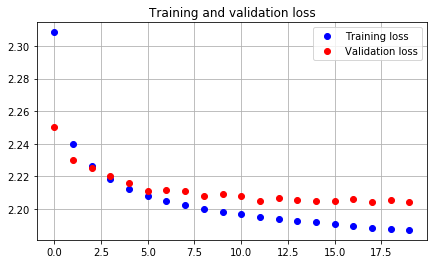

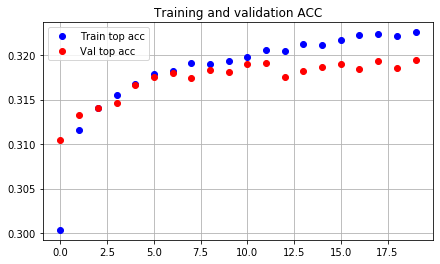

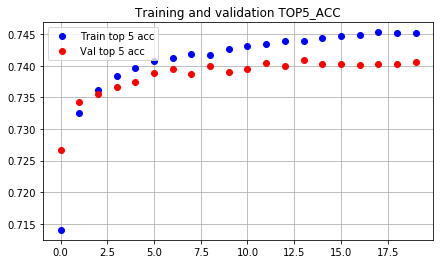

In [16]:
loss = fitting.history['loss']
val_loss = fitting.history['val_loss']
epochs = range(len(loss))
plt.figure(figsize=(7,4))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'ro', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.grid() 
plt.savefig('./Batc64HN128_64_Ep30_LOSS.png')
plt.show()

top_acc_train=fitting.history['accuracy']
top_acc=fitting.history['val_accuracy']
epochs = range(len(loss))
plt.figure(figsize=(7,4))
plt.plot(epochs, top_acc_train, 'bo', label='Train top acc')
plt.plot(epochs, top_acc, 'ro', label='Val top acc')
plt.title('Training and validation ACC')
plt.legend()
plt.grid() 
plt.savefig('./Batc64HN128_64_Ep30_ACC.png')
plt.show()

top5_acc_train=fitting.history['top_k_categorical_accuracy']
top5_acc=fitting.history['val_top_k_categorical_accuracy']
epochs = range(len(loss))
plt.figure(figsize=(7,4))
plt.plot(epochs, top5_acc_train, 'bo', label='Train top 5 acc')
plt.plot(epochs, top5_acc, 'ro', label='Val top 5 acc')
plt.title('Training and validation TOP5_ACC')
plt.legend()
plt.grid() 
plt.savefig('./Batc64HN128_64_Ep30_TOP5ACC.png')
plt.show()

In [13]:
####TEST DNN
print('------------Building DNN model--------------')
ShuffleInTraining=True
N_EPOCHS=30
N_HN_1=512
N_HN=256
N_LAYERS=3
N_BATCH=128
lookback=1024
Rate_Val=0.5
N_Val_OverSampler=int(np.around(N_AllTrain_OverSampler*Rate_Val))
N_Train_OverSampler=int(N_AllTrain_OverSampler-N_Val_OverSampler)
N_CLASS=len(allDF["Category"].unique())
input_dim=featuresArrayOverSampler.shape[1]
output_dim=N_CLASS

model = Sequential()
model.add(Dense(N_HN_1,input_dim=input_dim))
model.add(BatchNormalization())
model.add(PReLU())
# model.add(Dropout(dp))
for i in range(N_LAYERS):
    model.add(Dense(N_HN))
    model.add(BatchNormalization())    
    model.add(PReLU())
#   model.add(Dropout(dp))
model.add(BatchNormalization())
model.add(Dense(output_dim))
model.add(Activation('softmax'))
# model = multi_gpu_model(model, 2)gfyht76
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy', metrics.top_k_categorical_accuracy])

x_train,x_val,y_train,y_val = train_test_split(featuresArrayOverSampler,labelsArrayOverSampler,test_size=N_Val_OverSampler,train_size=N_Train_OverSampler, shuffle=True)
# x_train=featuresArray[0:N_Train,:]
# y_train=labelsArray[0:N_Train]
y_train = keras.utils.to_categorical(LabelEncoder().fit_transform(np.array(y_train)), num_classes=N_CLASS)
# x_val=featuresArray[N_Train:N_AllTrain,:] 
# y_val=labelsArray[N_Train:N_AllTrain]
y_val = keras.utils.to_categorical(LabelEncoder().fit_transform(np.array(y_val)), num_classes=N_CLASS)
print('------------DNN Training Go! Go! Go!!!!-----------')
# fitting=model.fit(x_train, y_train, epochs=N_EPOCHS, batch_size=N_BATCH,verbose=2,validation_data=(x_val,y_val),shuffle=True)
fitting=model.fit(x_train, y_train, epochs=N_EPOCHS, batch_size=N_BATCH,verbose=1,validation_data=(x_val,y_val),shuffle=True)

# acc_test, test_score,fitting, model = build_and_fit_model(features_train.values,labels_train,x_val=features_test.values,y_test=labels_test,hn=N_HN,layers=N_LAYERS,epochs=N_EPOCHS,verbose=2,dp=DP)
model.save('jjs_model_0124V3.h5')

------------Building DNN model--------------
------------DNN Training Go! Go! Go!!!!-----------
Train on 406265 samples, validate on 406264 samples
Epoch 1/30
406265/406265 [==============================] - 113s 278us/step - loss: 2.2575 - accuracy: 0.3249 - top_k_categorical_accuracy: 0.7347 - val_loss: 2.1835 - val_accuracy: 0.3337 - val_top_k_categorical_accuracy: 0.7495
Epoch 2/30
406265/406265 [==============================] - 117s 289us/step - loss: 2.1689 - accuracy: 0.3380 - top_k_categorical_accuracy: 0.7532 - val_loss: 2.1655 - val_accuracy: 0.3367 - val_top_k_categorical_accuracy: 0.7550
Epoch 3/30
406265/406265 [==============================] - 113s 278us/step - loss: 2.1485 - accuracy: 0.3414 - top_k_categorical_accuracy: 0.7585 - val_loss: 2.1575 - val_accuracy: 0.3382 - val_top_k_categorical_accuracy: 0.7558
Epoch 4/30
406265/406265 [==============================] - 112s 276us/step - loss: 2.1293 - accuracy: 0.3458 - top_k_categorical_accuracy: 0.7627 - val_loss: 2.1

KeyboardInterrupt: 

In [11]:
print('-----------DNN Evaluate-------------------')
acc_test = model.evaluate(x_test,y_test, batch_size=N_BATCH)
print(acc_test)
acc_test_overSampler = model.evaluate(featuresArray_test,labelsArray_test, batch_size=N_BATCH)
print(acc_test_overSampler)

-----------DNN Evaluate-------------------
162505/162505 [==============================] - 3s 18us/step
[2528.0585275140575, 0.027734531089663506, 1.0]
1344603/1344603 [==============================] - 23s 17us/step
[4965.687923595205, 0.025641025975346565, 1.0]


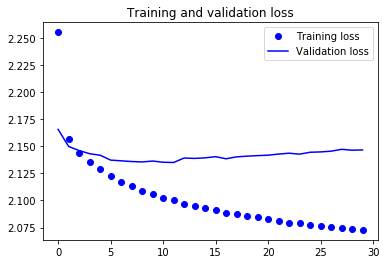

In [10]:
import matplotlib.pyplot as plt

loss = fitting.history['loss']
val_loss = fitting.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [11]:
print('-----------DNN Evaluate-------------------')
acc_test = model.evaluate(x_test,y_test, batch_size=N_BATCH)
print(acc_test)

-----------DNN Evaluate-------------------
87804/87804 [==============================] - 10s 110us/step
[918.3527435946424, 0.19818003475666046, 1.0]


In [11]:
model.save('jjs_model_0124V2.h5')

In [8]:
print('---------------------------Sort feature and label for LSTM------------------------------------')
featuresLSTM=features.values
labelsLSTM = labels.values
ShuffleInTraining=True
N_EPOCHS=3
N_HN=128
N_LAYERS=1
N_BATCH=128
lookback=1024
Rate_Val=0.2
N_Val=np.around(N_AllTrain*Rate_Val)
N_Train=N_AllTrain-N_Val
N_CLASS=len(allDF["Category"].unique())
input_dim=featuresLSTM.shape[1]
output_dim=N_CLASS

    #####按照年（第6列）月（第5列）日（第4列）时（第3列）排序
time_temp=featuresLSTM[:,2]+np.dot(featuresLSTM[:,3],100)+np.dot(featuresLSTM[:,4],10000)+np.dot(featuresLSTM[:,5],1000000)
features_label_time=np.column_stack((featuresLSTM,labelsLSTM))
features_label_time=np.column_stack((features_label_time,time_temp))
features_label_time =features_label_time[np.argsort(features_label_time[:,-1])]
featuresLSTM=features_label_time[:,0:featuresLSTM.shape[1]]
labelsLSTM=features_label_time[:,-2]
labelsLSTM = keras.utils.to_categorical(LabelEncoder().fit_transform(np.array(labelsLSTM)), num_classes=N_CLASS)
del features_label_time

print('--------------------------generator AllTrain_set, Train_set and Val_set for LSTM---------------------------------')
train_generator=generator(featuresLSTM, labelsLSTM, lookback=lookback, delay=1, min_index=0, max_index=N_Train, shuffle=ShuffleInTraining, batch_size=N_BATCH, step=1)
val_generator=generator(featuresLSTM, labelsLSTM, lookback=lookback, delay=1, min_index=N_Train+1, max_index=None, shuffle=ShuffleInTraining, batch_size=N_BATCH, step=1)
AllTrain_generator=generator(featuresLSTM, labelsLSTM, lookback=lookback, delay=1, min_index=0, max_index=None, shuffle=ShuffleInTraining, batch_size=N_BATCH, step=1)
AllTest_generator=generator(x_test, y_test, lookback=lookback, delay=1, min_index=0, max_index=None, shuffle=ShuffleInTraining, batch_size=N_BATCH, step=1)
val_steps = (N_Val-lookback) // N_BATCH
test_steps =(N_AllTest - lookback) // N_BATCH

---------------------------Sort feature and label for LSTM------------------------------------
--------------------------generator AllTrain_set, Train_set and Val_set for LSTM---------------------------------


In [9]:
LSTMmodel = Sequential()
LSTMmodel.add(layers.Flatten(input_shape=(lookback, input_dim)))
LSTMmodel.add(layers.Dense(N_HN, activation='relu'))
LSTMmodel.add(layers.Dense(output_dim))
model.add(Activation('softmax'))
LSTMmodel.compile(optimizer=RMSprop(), loss='categorical_crossentropy',metrics=['accuracy', metrics.top_k_categorical_accuracy])
# LSTMmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy', metrics.top_k_categorical_accuracy])

In [11]:
print('---------------------------------------LSTM GO GO GO!!!!---------------------------------------------')
history = LSTMmodel.fit_generator(train_generator,steps_per_epoch=50,epochs=N_EPOCHS,verbose=1,validation_data=val_generator,validation_steps=val_steps)

---------------------------------------LSTM GO GO GO!!!!---------------------------------------------
Epoch 1/3
50/50 [==============================] - 797s 16s/step - loss: 8.1904 - accuracy: 0.0864 - top_k_categorical_accuracy: 0.3411 - val_loss: 7.9591 - val_accuracy: 0.1394 - val_top_k_categorical_accuracy: 0.4280
Epoch 2/3
50/50 [==============================] - 784s 16s/step - loss: 8.0796 - accuracy: 0.1109 - top_k_categorical_accuracy: 0.3505 - val_loss: 7.2991 - val_accuracy: 0.0774 - val_top_k_categorical_accuracy: 0.3846
Epoch 3/3
50/50 [==============================] - 788s 16s/step - loss: 8.1813 - accuracy: 0.1255 - top_k_categorical_accuracy: 0.3256 - val_loss: 8.9437 - val_accuracy: 0.1139 - val_top_k_categorical_accuracy: 0.3852


In [13]:
print('--------------------------LSTM ReTraining On AllTrainSet (include trainSet and valSet) !!!!---------------------------------')
historyAll = LSTMmodel.fit_generator(AllTrain_generator,steps_per_epoch=50, epochs=1,verbose=1,validation_data=val_generator,validation_steps=val_steps)

--------------------------LSTM ReTraining On AllTrainSet (include trainSet and valSet) !!!!---------------------------------
Epoch 1/1
50/50 [==============================] - 820s 16s/step - loss: 8.1710 - accuracy: 0.1575 - top_k_categorical_accuracy: 0.3841 - val_loss: 7.1834 - val_accuracy: 0.1535 - val_top_k_categorical_accuracy: 0.4441


In [ ]:
acc_test = LSTMmodel.evaluate_generator(AllTest_generator, steps=10000,  verbose=1)

 9226/10000 [==========================>...] - ETA: 2:14

In [14]:
print('-----------LSTM Evaluate on AllTestSet-------------------')
####
#需要将train_X_ALL和test_X拼接在一起，先计算一下train_X_ALL的行数，然后，根据lookback来确定test_X从哪一行开始
####
#evaluate_generator(generator, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0)
acc_test = LSTMmodel.evaluate_generator(AllTest_generator, steps=N_AllTest,  verbose=1)
# acc_test = LSTMmodel.evaluate(test_X,test_Y, batch_size=N_BATCH)
print(acc_test)

-----------LSTM Evaluate on AllTestSet-------------------
87804/87804 [==============================] - 19971s 227ms/step
[9.870048522949219, 0.00019201147370040417, 0.28379303216934204]


In [35]:
OnlyLSTM=True#False
if OnlyLSTM:
    print('------------Begin LSTM--------------')
    featuresLSTM=features.values
    labelsLSTM = labels.values
        #####按照年（第6列）月（第5列）日（第4列）时（第3列）排序
    time_temp=featuresLSTM[:,2]+np.dot(featuresLSTM[:,3],100)+np.dot(featuresLSTM[:,4],10000)+np.dot(featuresLSTM[:,5],1000000)
    features_label_time=np.column_stack((featuresLSTM,labelsLSTM))
    features_label_time=np.column_stack((features_label_time,time_temp))
    features_label_time =features_label_time[np.argsort(features_label_time[:,-1])]
    featuresLSTM=features_label_time[:,0:featuresLSTM.shape[1]]
    labelsLSTM=features_label_time[:,-2]
    labelsLSTM = keras.utils.to_categorical(LabelEncoder().fit_transform(np.array(labelsLSTM)), num_classes=N_CLASS)
    del features_label_time

    N_EPOCHS=40
    N_HN=128
    N_LAYERS=1
    N_BATCH=64
    lookback=4056
    TestRate=0.2
    size_Train=trainDF.shape[0]*TestRate
    input_dim=featuresLSTM.shape[1]
    output_dim=N_CLASS
    
    print('--------------------------generator Train_set and Val_set for LSTM---------------------------------')
    train_X, train_Y=generator(featuresLSTM, labelsLSTM, lookback=lookback, delay=1, min_index=0, max_index=size_Train, shuffle=True, batch_size=N_BATCH, step=1)
    val_X, val_Y=generator(featuresLSTM, labelsLSTM, lookback=lookback, delay=1, min_index=size_Train+1, max_index=None, shuffle=True, batch_size=N_BATCH, step=1)
 
    LSTMmodel = Sequential()
    LSTMmodel.add(layers.Flatten(input_shape=(lookback, input_dim)))
    LSTMmodel.add(layers.Dense(N_HN, activation='relu'))
    LSTMmodel.add(layers.Dense(output_dim))
    LSTMmodel.compile(optimizer=RMSprop(), loss='categorical_crossentropy',metrics=['accuracy', metrics.top_k_categorical_accuracy])
    # LSTMmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy', metrics.top_k_categorical_accuracy])
    print('---------------------------------------LSTM GO GO GO!!!!---------------------------------------------')
    history = LSTMmodel.fit(train_X,train_Y, epochs=N_EPOCHS,verbose=1,validation_data=(val_X, val_Y))

    print('--------------------------LSTM ReTraining On trainSet and valSet!!!!---------------------------------')
    train_X_ALL, train_Y_ALL=generator(featuresLSTM, labelsLSTM, lookback=lookback, delay=1, min_index=0, max_index=None, shuffle=True, batch_size=N_BATCH, step=1)
    historyAll = LSTMmodel.fit(train_X_ALL, train_Y_ALL, epochs=N_EPOCHS,verbose=1,validation_data=(val_X, val_Y))

    print('-----------LSTM Evaluate ALL-------------------')
    ####

    #需要将train_X_ALL和test_X拼接在一起，先计算一下train_X_ALL的行数，然后，根据lookback来确定test_X从哪一行开始

    ####
    test_X, test_Y=generator(x_test, y_test, lookback=lookback, delay=1, min_index=0, max_index=None, shuffle=True, batch_size=N_BATCH, step=1)
    acc_test = LSTMmodel.evaluate(test_X,test_Y, batch_size=N_BATCH)
    print(acc_test)
else:   
    N_EPOCHS=21
    N_HN=256
    N_HN_1=512
    N_LAYERS=2
    N_BATCH=64
    DP=0.5
    SORTbyTime=False #是否需要根据时间顺序，留出后Test_size个样本用于测试
    TestRate=0.2 #当SORTbyTime=False 时，该值才起作用
    Test_size=200000#当SORTbyTime=True 时，该值才起作用
    split_count=1#当SORTbyTime=True 时，该值才起作用
    split_size=int(Test_size/split_count)#当SORTbyTime=True 时，该值才起作用
    N_hight=featuresArray.shape[0]
    print('------------train_val_split--------------')
    for t_i in range(split_count):
        if SORTbyTime:
            # t_i=t0_i+1
            print('--------NNN_spllit_NNN_spllit_NNN_spllit_NNN_spllit_---------')
            print(t_i)
            x_train=featuresArray[0:N_hight-Test_size+t_i*split_size,:]
            y_train=labelsArray[0:N_hight-Test_size+t_i*split_size]

            x_val=featuresArray[N_hight-Test_size+t_i*split_size:N_hight-Test_size+(t_i+1)*split_size,:]
            y_val=labelsArray[N_hight-Test_size+t_i*split_size:N_hight-Test_size+(t_i+1)*split_size]
        else:
            print('------------train_val_split_Shuffle--------------')
            x_train,x_val,y_train,y_val = train_test_split(featuresArray,labelsArray,test_size=TestRate,shuffle=True)
        print('------------to_categorical--------------')
        y_train = keras.utils.to_categorical(LabelEncoder().fit_transform(np.array(y_train)), num_classes=N_CLASS)
        y_val = keras.utils.to_categorical(LabelEncoder().fit_transform(np.array(y_val)), num_classes=N_CLASS)


        ##########################################################################
        print('------------Building model--------------')
        input_dim=x_train.shape[1]
        output_dim=N_CLASS
        model = Sequential()
        model.add(Dense(N_HN_1,input_dim=input_dim,init='glorot_uniform'))
        model.add(BatchNormalization())
        model.add(PReLU())
        # model.add(Dropout(dp))
        for i in range(N_LAYERS):
            model.add(Dense(N_HN, init='glorot_uniform'))
            model.add(BatchNormalization())    
            model.add(PReLU())    
        #   model.add(Dropout(dp))
        model.add(BatchNormalization())
        model.add(Dense(output_dim, init='glorot_uniform'))
        model.add(Activation('softmax'))
        # model = multi_gpu_model(model, 2)
        model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy', metrics.top_k_categorical_accuracy])
        if OnlyLSTM:
            print('------------Go! Go! Go!!!!-----------')
            fitting=model.fit(x_train, y_train, epochs=N_EPOCHS, batch_size=N_BATCH,verbose=1,validation_data=(x_val,y_val))
            # acc_test, test_score,fitting, model = build_and_fit_model(features_train.values,labels_train,x_val=features_test.values,y_test=labels_test,hn=N_HN,layers=N_LAYERS,epochs=N_EPOCHS,verbose=2,dp=DP)
            # model.save('jjs_model_0112.h5')
            print('-----------Evaluate-------------------')
            acc_test = model.evaluate(x_test,y_test, batch_size=N_BATCH)
            print(acc_test)
            if SORTbyTime:
                del model

------------Begin LSTM--------------


KeyboardInterrupt: 

In [40]:
import tensorflow as tf
from keras import backend as K
 
K.clear_session()
tf.reset_default_graph()